# DC2 Object Catalog Run2.2i GCR tutorial -- Part IV: accessing photo-z

Owners: **Yao-Yuan Mao [@yymao](https://github.com/LSSTDESC/DC2-analysis/issues/new?body=@yymao)**, 
        **Sam Schmidt [@sschmidt23](https://github.com/LSSTDESC/DC2-analysis/issues/new?body=@sschmidt23)**

Last Verifed to Run: **2020-06-09** (by @sschmidt23)

This notebook will show you how to access the "add-on" columns that provide the photometric redshift (photo-z) information for the DC2 Object Catalog (Run 2.2i). 

__Learning objectives__: After going through this notebook, you should be able to:
  1. Load and efficiently access a DC2 object catalog (+ photo-z) with the GCR
  2. Understand how the photo-z data are stored / represented
  3. Look at an example of galaxy photo-z distributions
  
__Logistics__: This notebook is intended to be run through the Jupyter Lab NERSC interface available here: https://jupyter.nersc.gov/. To setup your NERSC environment, please follow the instructions available here: https://confluence.slac.stanford.edu/display/LSSTDESC/Using+Jupyter+at+NERSC

__Other notes__: 
If you restart your kernel, or if it automatically restarts for some reason, all imports and variables will become undefined so, you will have to re-run everything.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import GCRCatalogs
from GCR import GCRQuery
GCRCatalogs.__version__

'0.18.1'

## Load the catalog

Loading the object catalog with photo-z add-on. The catalog name is `dc2_object_run2.2i_with_photoz`. 

It takes a few seconds for the catalog instance to initiate.

In [3]:
cat = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr3_with_photoz')


## Photo-z access methods

There are several photo-z related quantities available in the catalog, a summary of which can be found on this Confluence page:
https://confluence.slac.stanford.edu/display/LSSTDESC/List+of+available+DC2+catalogs+created+by+PhotoZ

There are photo-z estimates in the form of both a single number "point estimate" for each galaxy, as well as a 1D redshift probability density function (PDF) representing the posterior probability of the galaxy being at a given redshift calculated on a specific redshift grid.

There are multiple single point estimates:
1. `photoz_mode`: the mode of the redshift PDF, the highest peak of the posterior probability
2. `photoz_mean`: the weighted mean of the redshift PDF.
3. `photoz_median`: the redshift where the redshift CDF is equal to 0.5.

The redshift pdf is stored in the multi-valued column `photoz-pdf`.  The grid of redshifts at which the posterior probability is evaluated is stored in the catalog with the special attribute of `photoz_pdf_bin_centers`.  You can access this attribute for catalog cat with something like `zgrid = cat.photoz_pdf_bin_centers`

There are three additional columns that can be used as various quality flags:
1. `photoz_odds` (see Benitez 2000) is a measure of the integrated amount or probaility within a fixed distance around `photoz_mode`.  If the redshift posterior is single peaked and narrow this number will be close to 1.0, if the posterior is multi-peaked and/or broad it is likely to be smaller.  Thus, high values of `photoz_odds` can be used as an indicator of photo-z quality.
2. `photoz_mode_ml_red_chi2` is the reduced chi-squared value for the maximum likelihood estimate of the best fit template at the photo-z mode.  If this chi-squared value is very large, it indicates that none of the SED templates employed by the photo-z code were good fits to the observed colors, and thus the redshift may be suspect. High values may also occur for very bright galaxies where photometric errors are small and thus chi-squared values can grow large.

We will demonstrate access methods for several of these quantities in detail. You can notice that all the photo-z columns have a prefix of `photoz_`. 

Let's first make sure that these columns are indeed available. 

In [4]:
sorted(q for q in cat.list_all_quantities() if q.startswith('photoz_'))

['photoz_mean',
 'photoz_median',
 'photoz_mode',
 'photoz_mode_ml',
 'photoz_mode_ml_red_chi2',
 'photoz_odds',
 'photoz_pdf']

Let's now try access the photo-z data! Everything you already about the GCR access of object catalogs will still apply. 
Including the use of `filters` and `native_filters` (`native_filters` is used for selecting tracts mostly). We will access the single tract 4850.

In [5]:
data = cat.get_quantities(['photoz_mode'], 
                          filters=['photoz_mode < 0.2', 'mag_i < 26'], 
                          native_filters=['tract==4850'])

# check if the filters work
print((data['photoz_mode'] < 0.2).all())

True


/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1/envs/desc-dev/lib/python3.7/site-packages/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky


Now, if you want to make a plot of the PDF for a galaxy or galaxies, you will need to access the `photoz_pdf` column. Note that each entry stores an array, so use with care!

As an example, let's just load one tract (using the `return_iterator` feature) of the full PDFs and also peak and mean values at the same time.  The first few tracts have very few objects, some of which are only detected in a handful of bands, so we'll load the 14th tract:

In [6]:
xcat = cat.get_quantities(['photoz_pdf', 'photoz_mode', 'photoz_mean'], return_iterator=True)
for i in range(14):
    data = next(xcat)

There are 684,634 objects in this tract, and there are 301 bins in the photo-z PDF. The photoz_pdf data is a 1D array has a shape of (684634,), *but* each entry stores an array of 301 values. 

In [7]:
data['photoz_pdf'].shape

(684634,)

Now, let's plot 10 example PDFs.  We will plot every 100th PDF as this shows a bit more variety in PDF shapes.
The PDFs were evaluated on a set grid of redshift values.  For run2.2 this grid extends to z=3.0.<br>
To get the array of bin center values, you can access the `photoz_pdf_bin_centers` attribute, as demonstrated below.  
We overplot the `photoz_mode` and `photoz_mean` values as well.

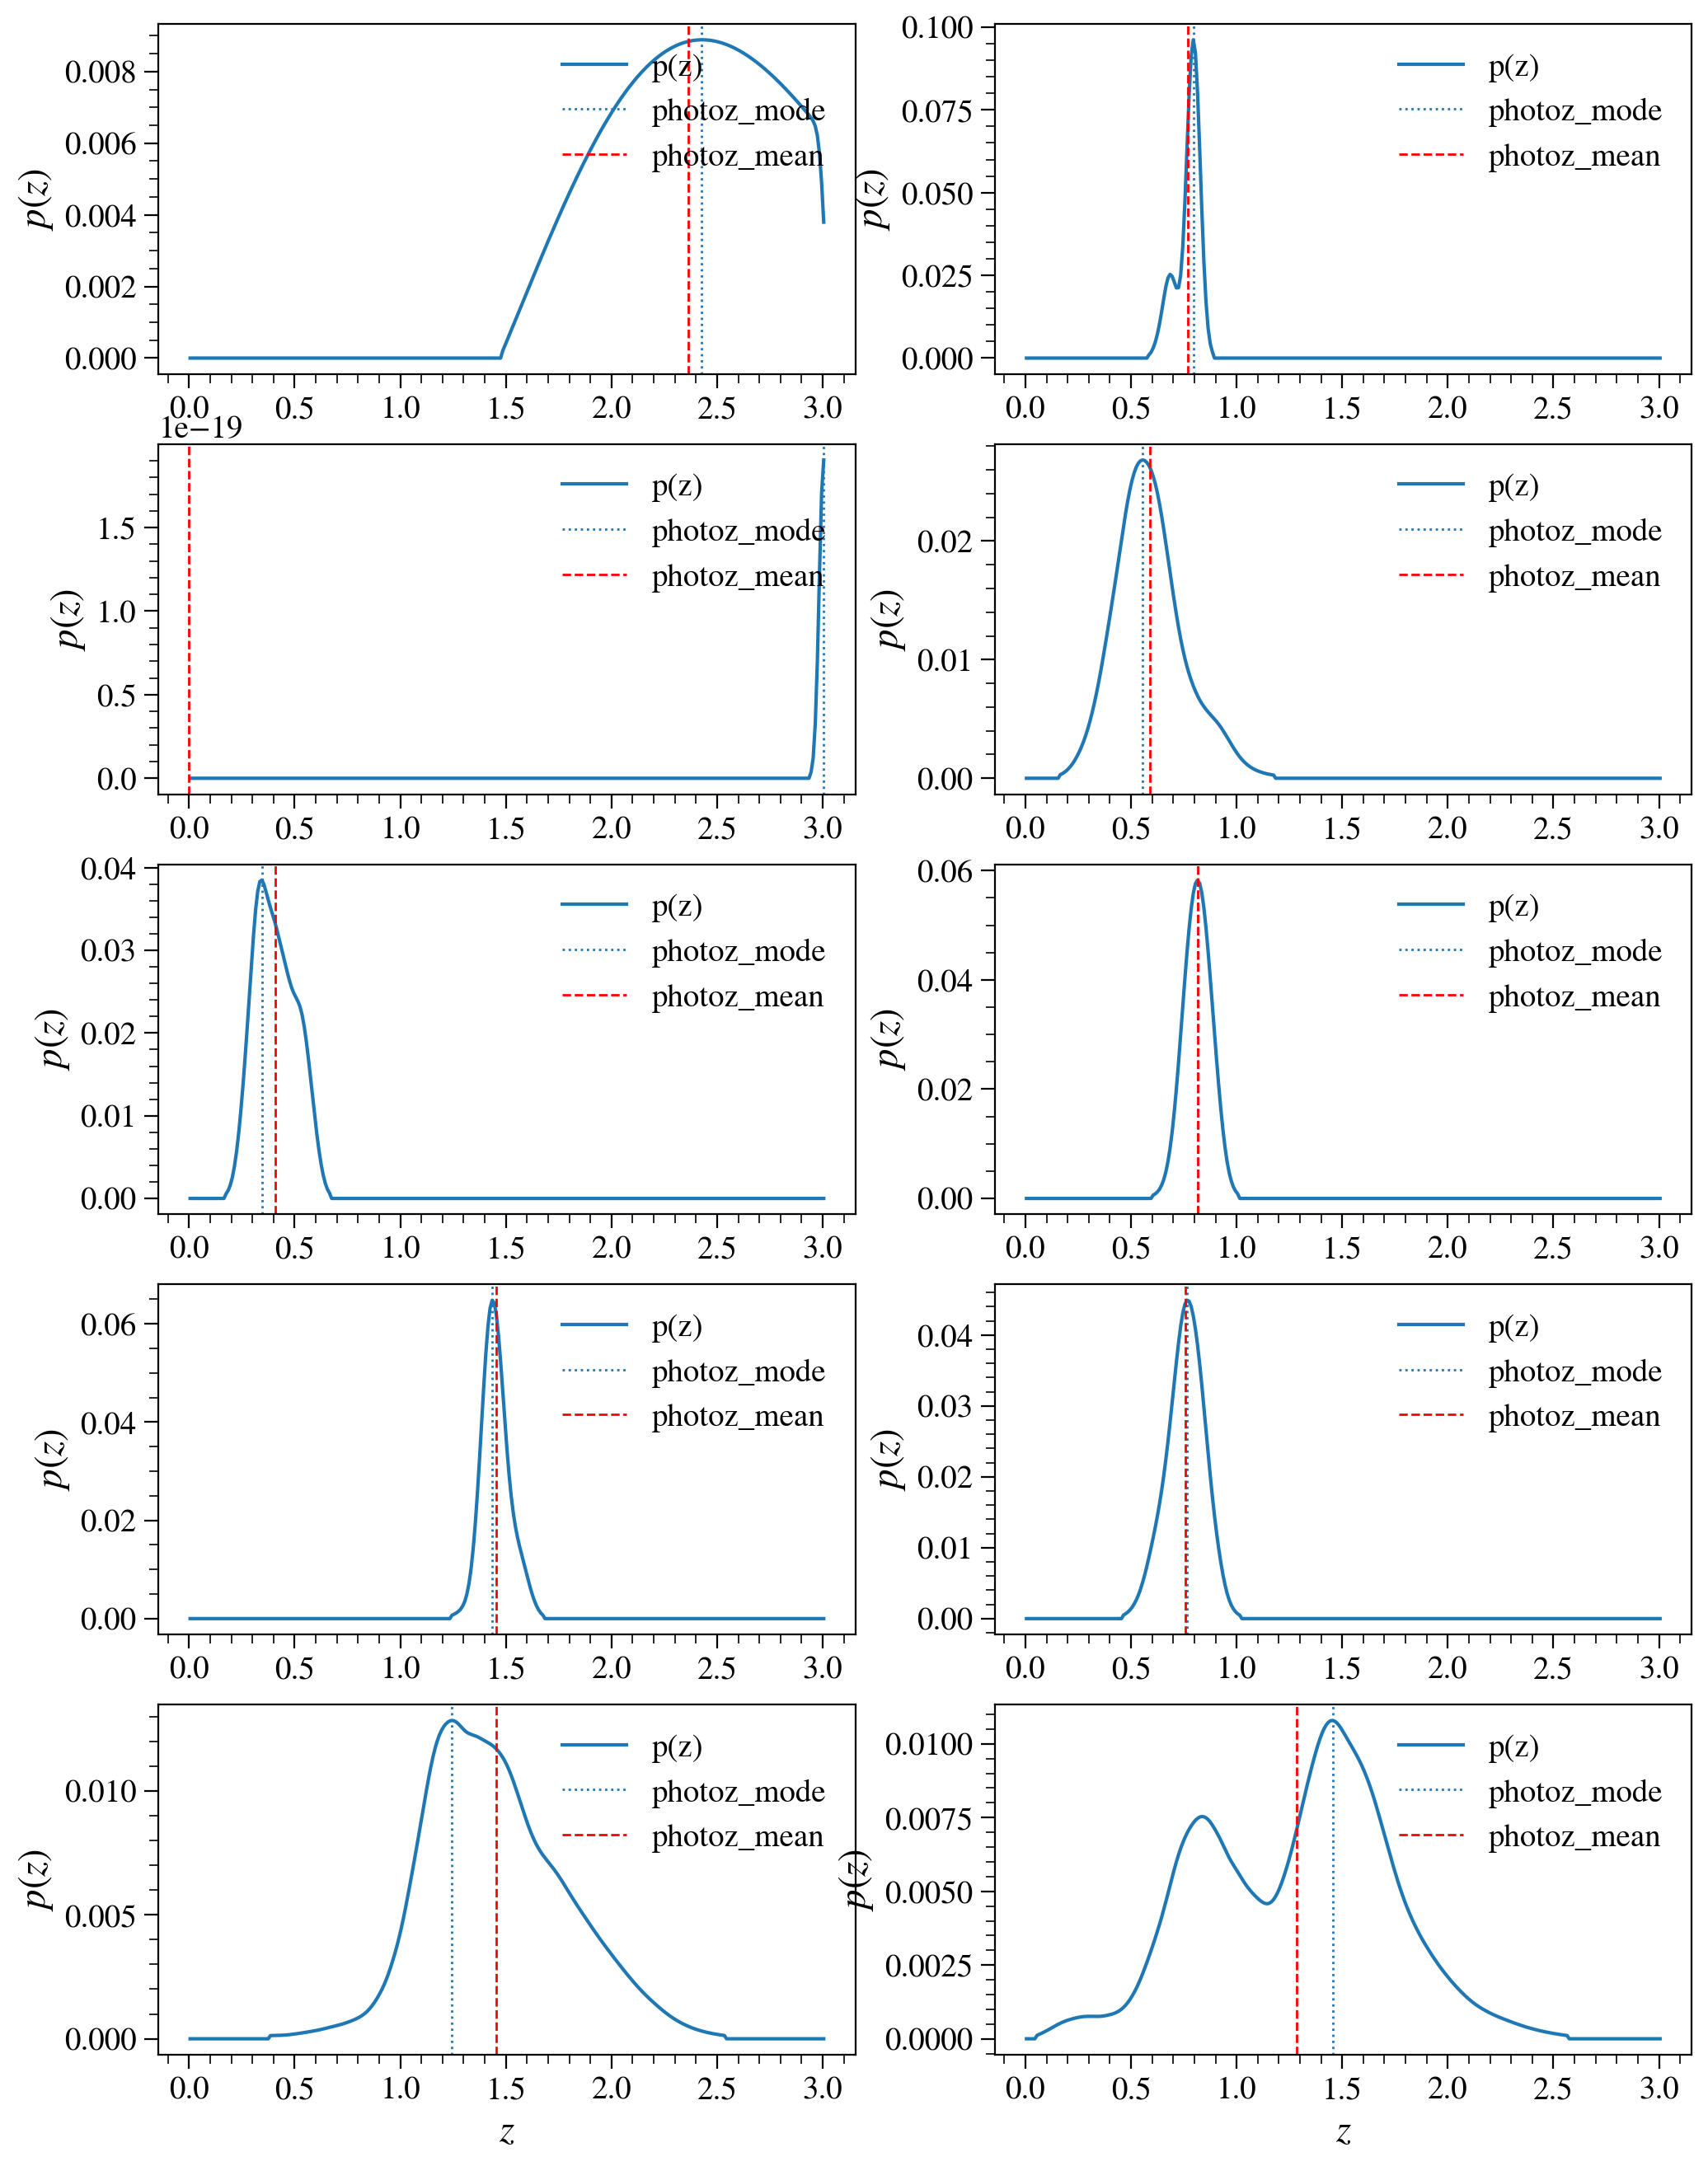

In [8]:
fig, ax = plt.subplots(5, 2, figsize=(12,16))
for pdf, z_peak, z_mean, ax_this in zip(data['photoz_pdf'][::100], data['photoz_mode'][::100],
                                        data['photoz_mean'][::100], ax.flat):
    l = ax_this.plot(cat.photoz_pdf_bin_centers, pdf,label='p(z)');
    ax_this.axvline(z_peak, color=l[0].get_color(), ls=':', lw=1,label='photoz_mode');
    ax_this.axvline(z_mean,color='r',ls='--',lw=1,label='photoz_mean');
    ax_this.set_xlabel('$z$');
    ax_this.set_ylabel('$p(z)$');
    ax_this.legend(loc='upper right')

We see that `photoz_mode` does, indeed, correspond to the mode/peak of the posterior.  `photoz_mean` lies at the weighted mean redshift.  For multi-peaked posteriors this position can actually be in a location of relatively low probability between two peaks.  We see a variety of PDF shapes: narrow unimodal; broad and/or tailed; and multimodal distributions.  This is due to a combination of the galaxy's observed colors and magnitude uncertainties.

## Example

Now that we have learned all the access methods, let's try to work out an example!

First of all, let's define a set of reasonable cuts to give us galaxies

In [9]:
cuts = [
    GCRQuery('extendedness > 0'),     # Extended objects
    GCRQuery((np.isfinite, 'mag_i')), # Select objects that have i-band magnitudes
    GCRQuery('clean'), # The source has no flagged pixels (interpolated, saturated, edge, clipped...) 
                       # and was not skipped by the deblender
    GCRQuery('snr_i_cModel > 20'),    # SNR > 20
    GCRQuery('snr_r_cModel > 20'),
    GCRQuery('snr_g_cModel > 20'),
    GCRQuery('mag_i_cModel < 23'),    # cModel imag brighter than 23
    GCRQuery('mag_i_cModel > 20')     # cModel imag fainter than 20 (exclude super bright objects)
]

Now let's make some plots!  Let's compare the histogram of photoz_mode values to the sum of the individual PDF values, the "stacked" PDF being a common (but not statistically correct) way of estimating redshift distributions:

In [10]:
data = cat.get_quantities(['photoz_mode', 'mag_g_cModel', 'mag_r_cModel', 'mag_i_cModel','photoz_pdf'], filters=cuts, native_filters=['tract==4850'])

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1/envs/desc-dev/lib/python3.7/site-packages/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky
/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1/envs/desc-dev/lib/python3.7/site-packages/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky


We can construct a rough estimate for the N(z) by summing the individual galaxy PDFs in `photoz_pdf`, and compare the results of this sum to the histogram of the single point `photoz_mode` values.

In [11]:
sumpdf = np.sum(data['photoz_pdf'],axis=0)

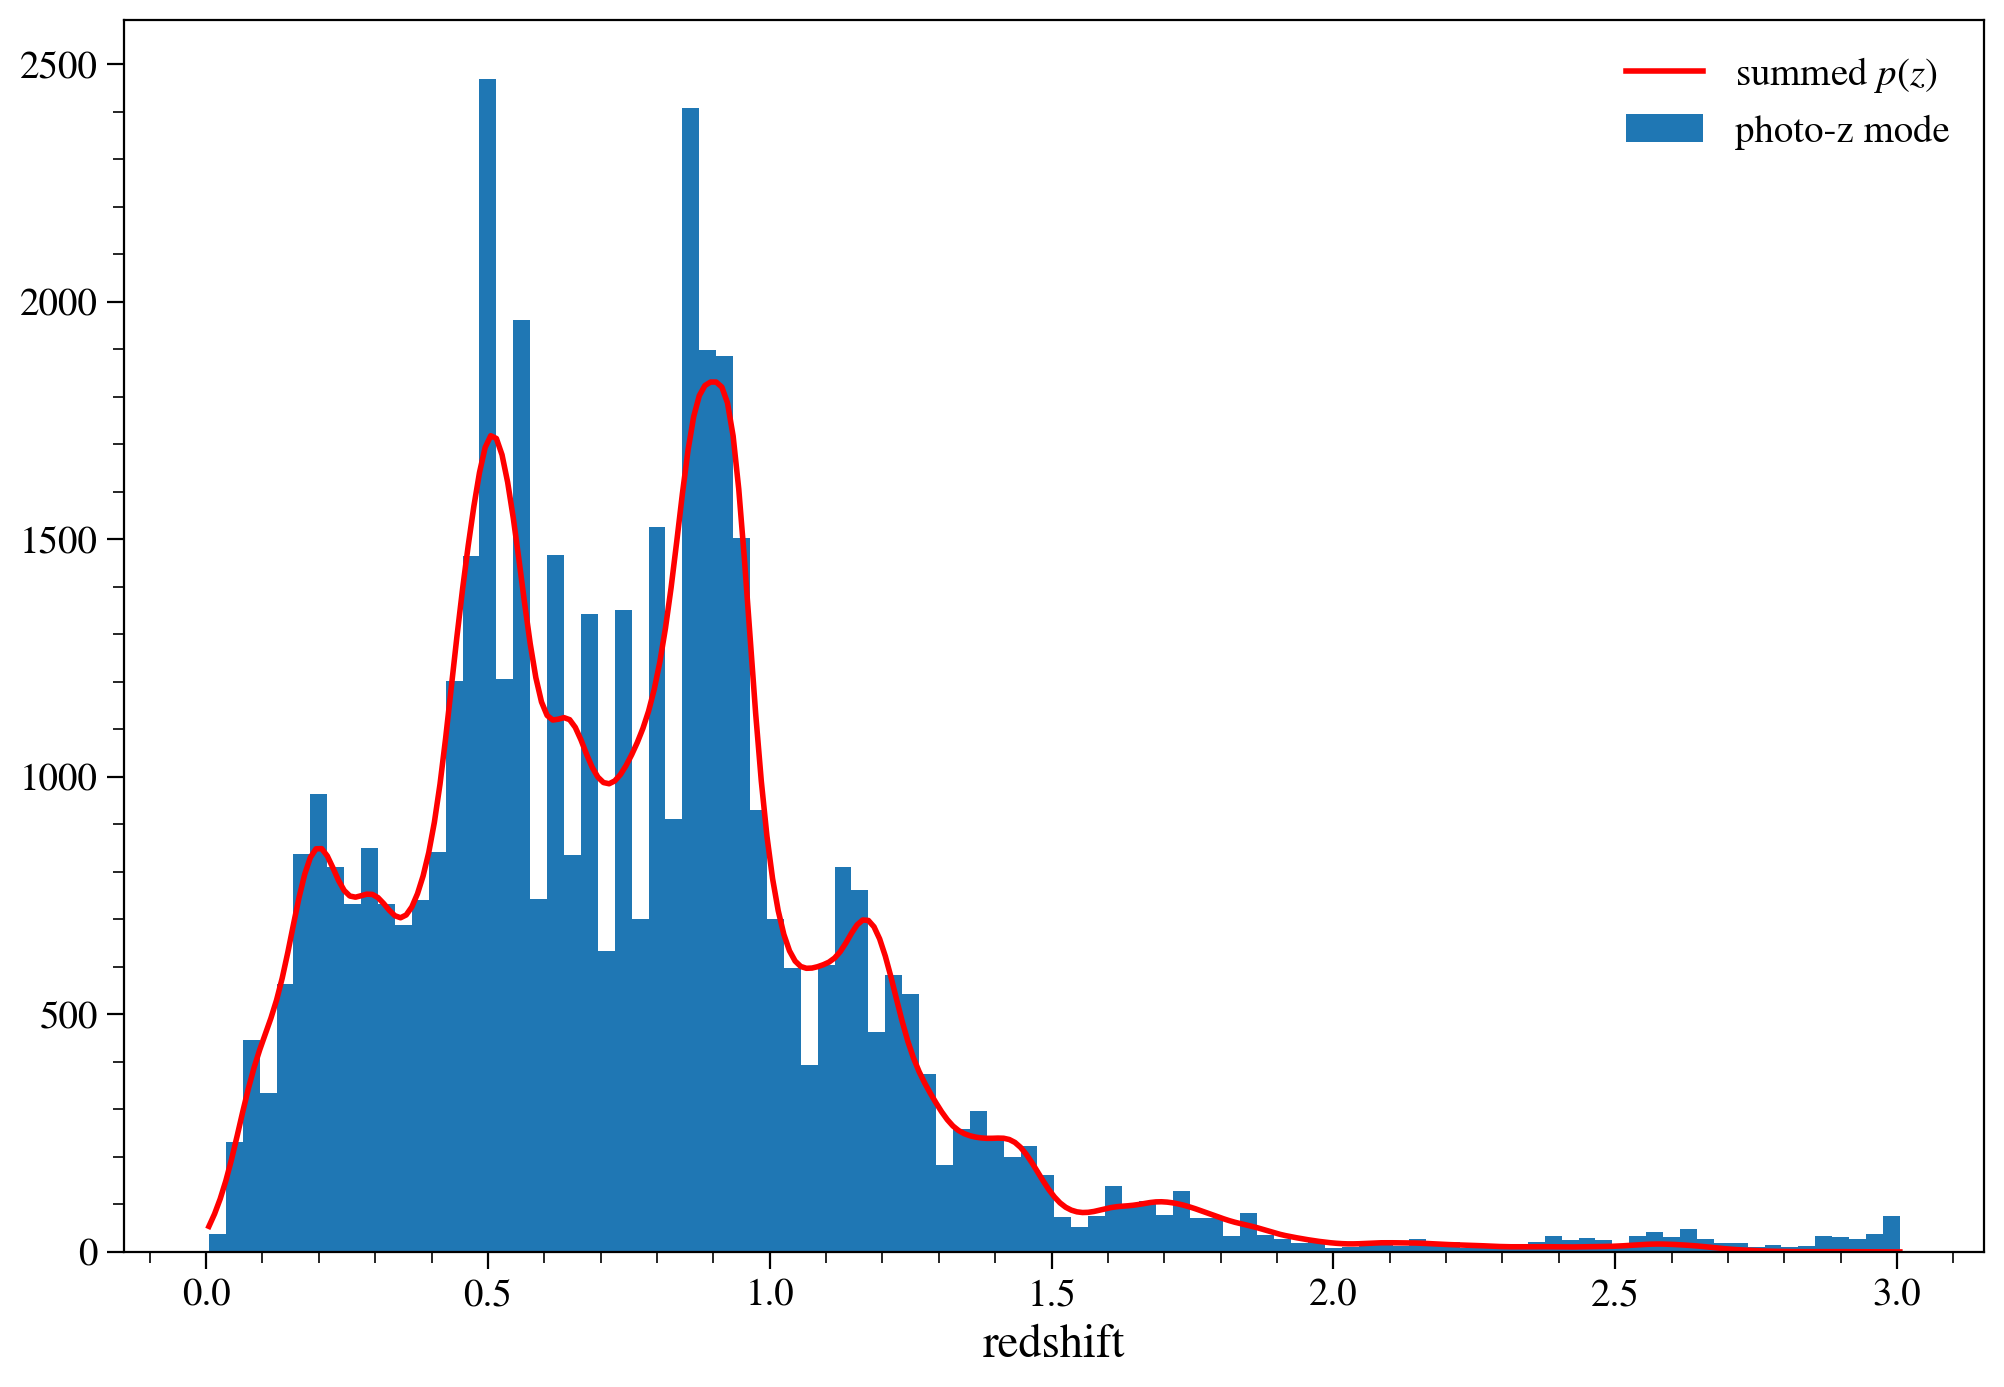

In [12]:
fig = plt.figure(figsize=(12,8))
plt.hist(data['photoz_mode'], 100, label="photo-z mode");
plt.plot(cat.photoz_pdf_bin_centers, sumpdf*3.,label="summed $p(z)$",lw=2,c='r');
plt.xlabel("redshift");
plt.legend(loc='upper right');

The `photoz_mode` and `photoz_pdf` shapes roughly agree, though we see a more smooth distribution with the full posteriors.  We also see a reduction of the anomalous high redshift features that appear with `photoz_mode`, where the posteriors are multi-peaked: using the full PDFs properly puts some of this probability at lower redshift rather than assigning to the single high redshift value.

Let's also plot a color-color diagram and color code by the `photoz_mode` value

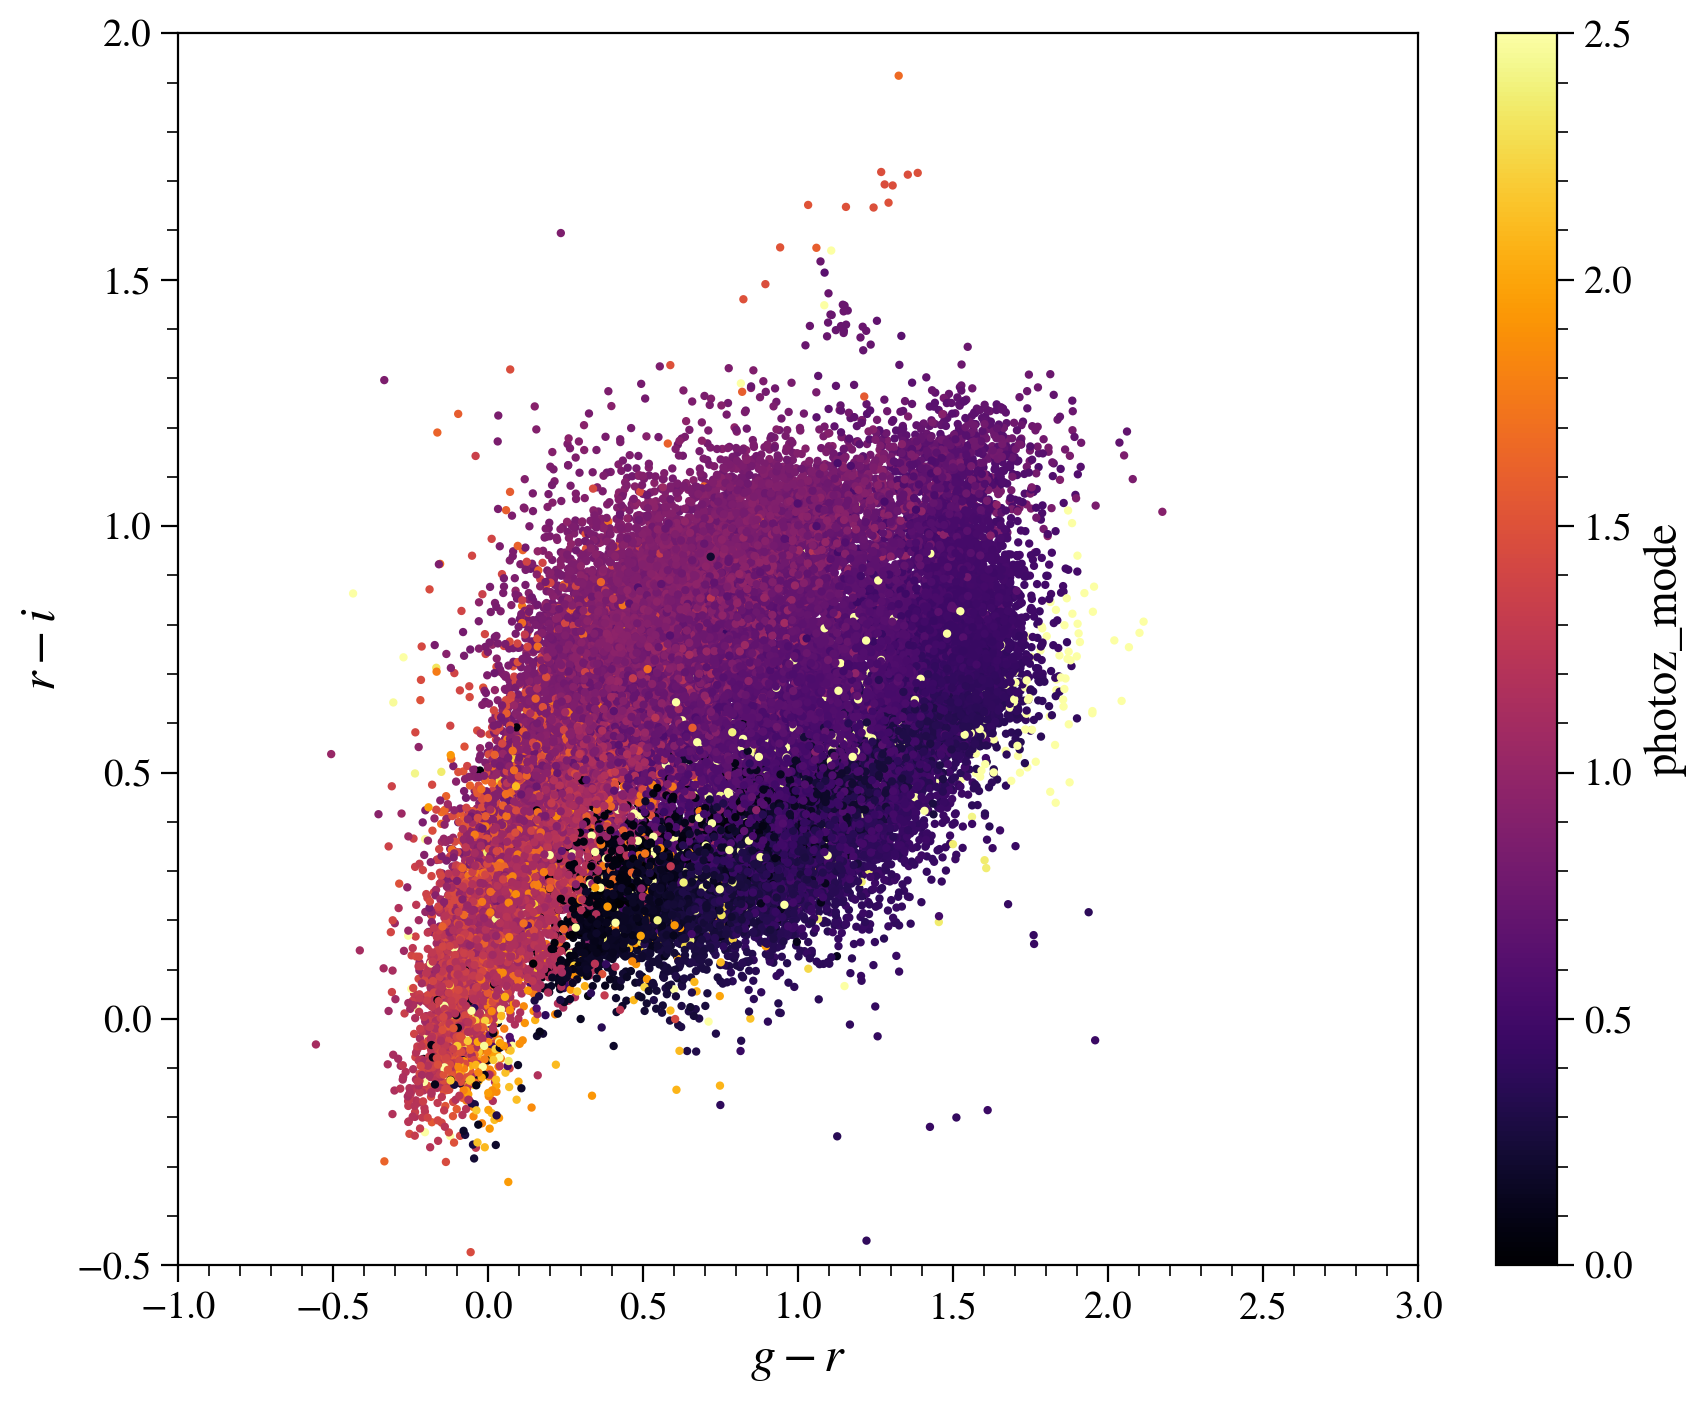

In [13]:
fig = plt.figure(figsize=(10,8))
plt.scatter(data['mag_g_cModel'] - data['mag_r_cModel'],
            data['mag_r_cModel'] - data['mag_i_cModel'],
            c=data['photoz_mode'], s=4, vmin=0, vmax=2.5,cmap='inferno');

plt.xlim(-1, 3);
plt.ylim(-0.5, 2);
plt.xlabel('$g-r$',fontsize=18);
plt.ylabel('$r-i$',fontsize=18);
plt.colorbar(label='photoz_mode');

# Food for thought: Look at how the photo-z values are distributed in this color-color space. Is this behavior expected?

We can see a strong correlation between redshift and position in color space, however the colors are determined by both the SED shape and redshift, so we also see degenerate areas, particularly at the blue end near color = 0.0 where low and high redshift solutions are close in the observed color space.  

Now let's examine a tomographic slice selected in terms of photoz_mode:

In [14]:
bin_cut = GCRQuery('photoz_mode > 0.6', 'photoz_mode < 0.8').mask(data)
sumpdf_bin = np.sum(data['photoz_pdf'][bin_cut],axis=0)

(0.25, 1.25)

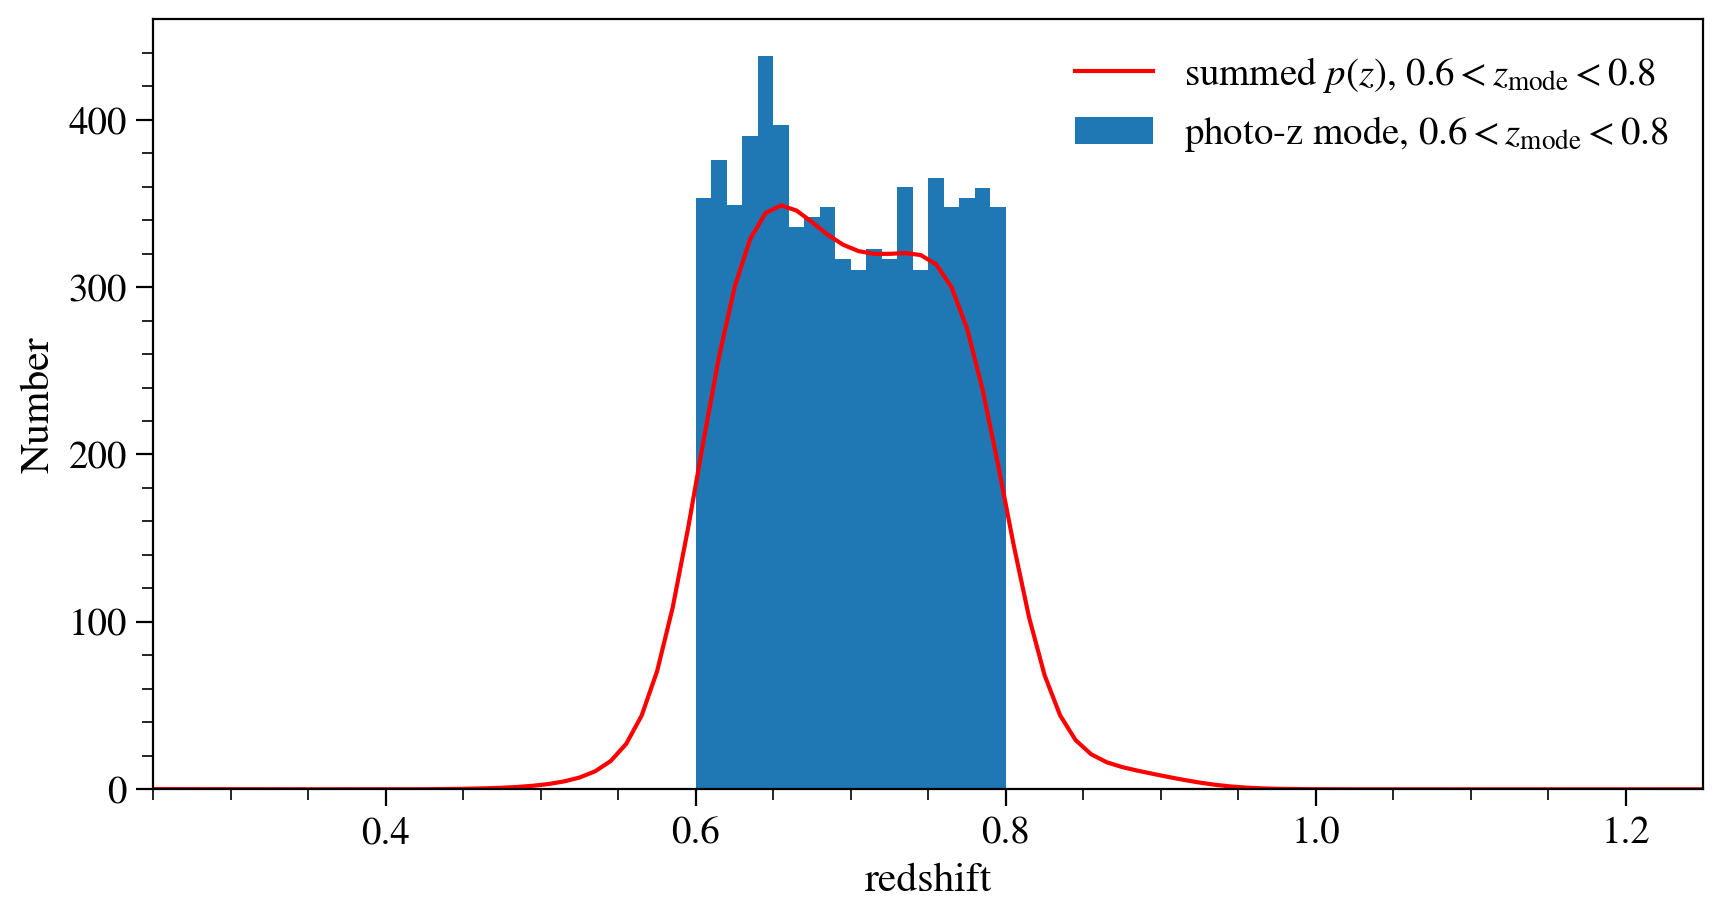

In [15]:
fig = plt.figure(figsize=(10,5))
plt.hist(data['photoz_mode'][bin_cut], bins = np.arange(0.0,3.01,.01), label=r'photo-z mode, $0.6 < z_{\rm mode} < 0.8$');
plt.plot(cat.photoz_pdf_bin_centers, sumpdf_bin,c='r', label=r'summed $p(z)$, $0.6 < z_{\rm mode} < 0.8$');
plt.xlabel("redshift",fontsize=15);
plt.ylabel("Number",fontsize=15)
plt.legend(loc='upper right');
plt.xlim(0.25,1.25)

We see that, while the `photoz_mode` values have been selected in a narrow range, the summed PDF values show "tails" that extend beyond the nominal bin.  This illustrates the uncertain values in photo-z estimates that are not easily summed up in a single number like `photoz_mode`.

Let's look at the location of galaxies within this tomographic bin in color space:

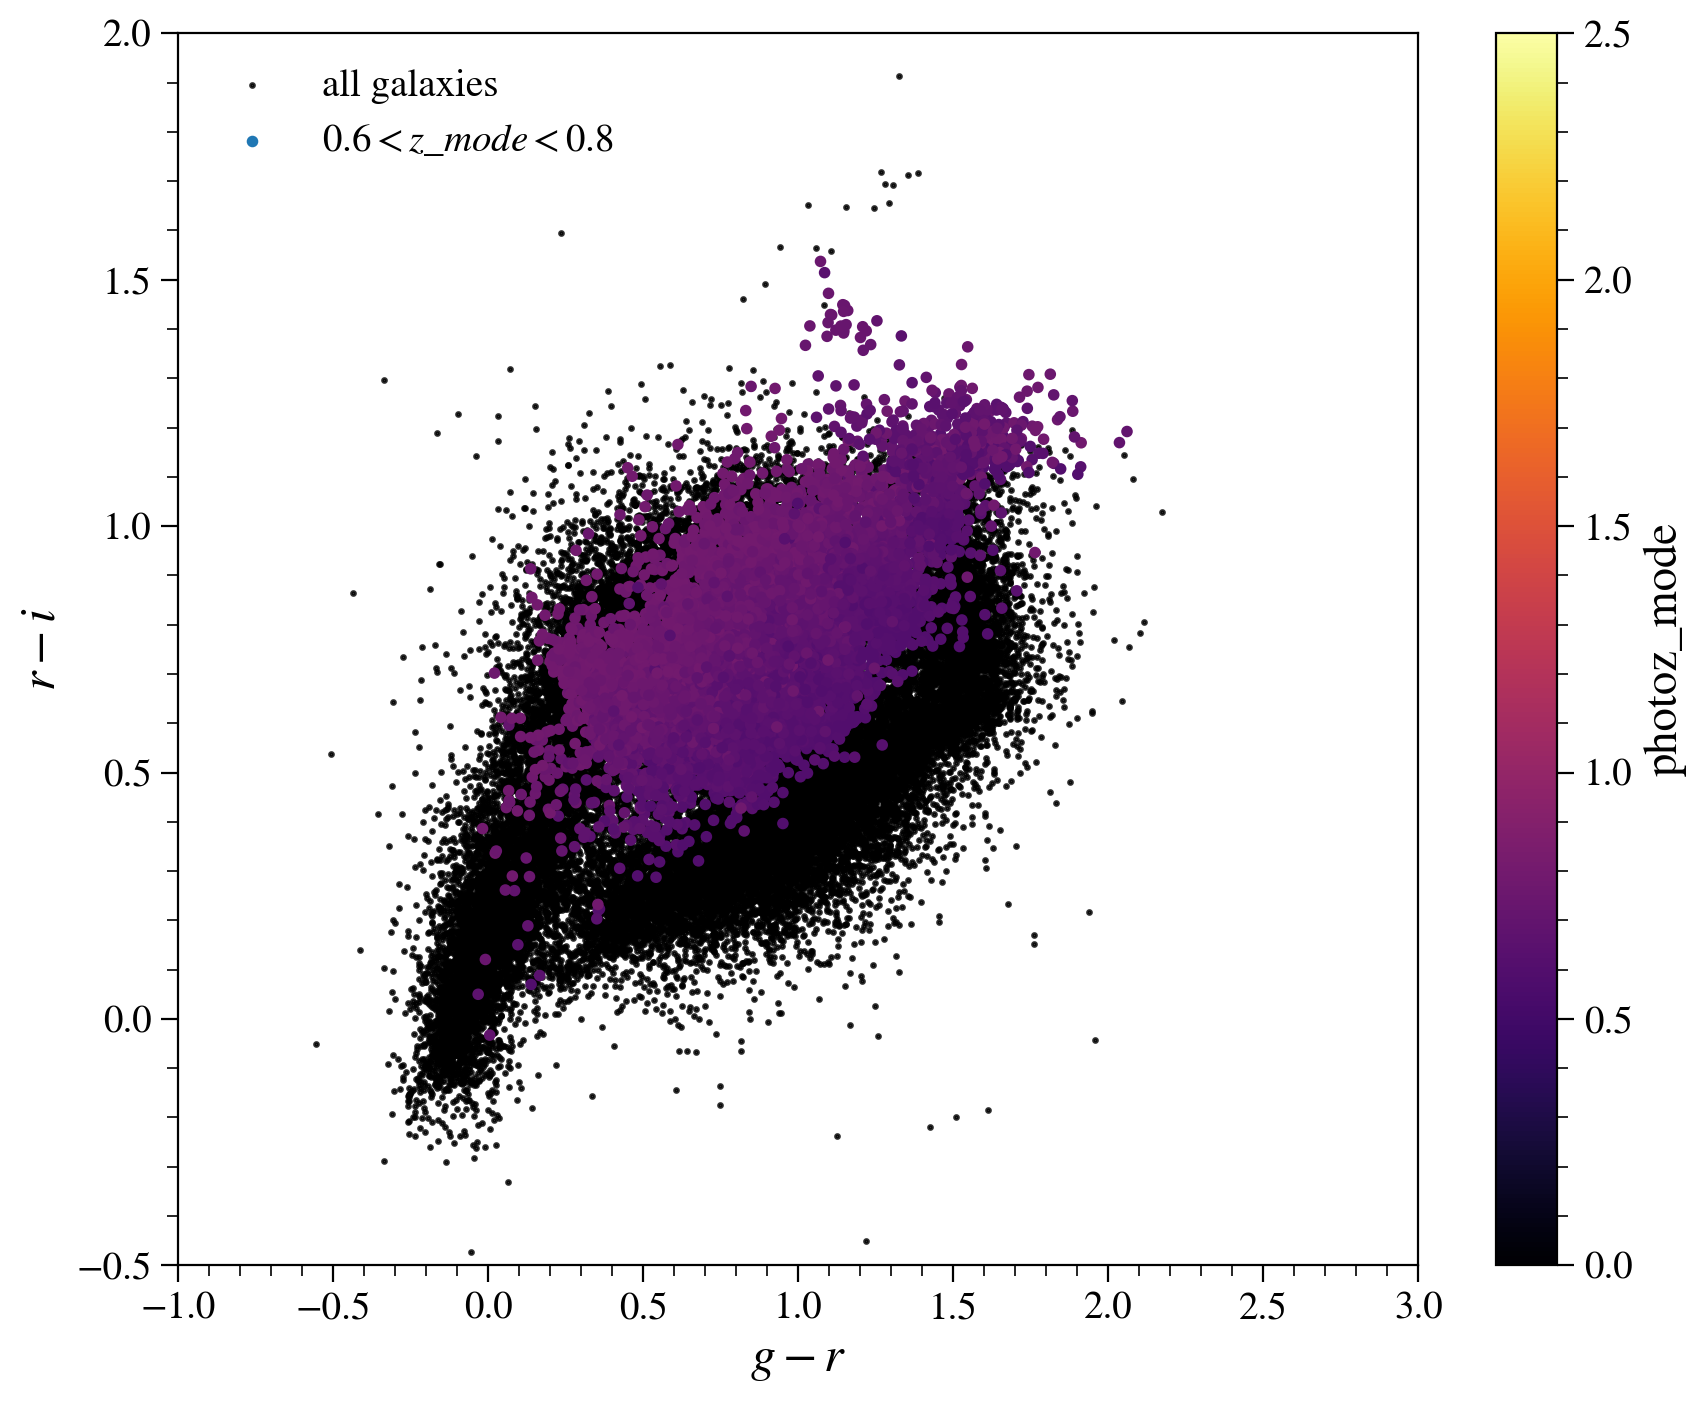

In [16]:
fig = plt.figure(figsize=(10,8))
plt.scatter(data['mag_g_cModel'] - data['mag_r_cModel'],
            data['mag_r_cModel'] - data['mag_i_cModel'],
            c='k',s=2,alpha=0.8,label='all galaxies');
plt.scatter(data['mag_g_cModel'][bin_cut] - data['mag_r_cModel'][bin_cut],
            data['mag_r_cModel'][bin_cut] - data['mag_i_cModel'][bin_cut],
            c=data['photoz_mode'][bin_cut], s=10, vmin=0, vmax=2.5, cmap='inferno',
            label='$0.6<z\_mode<0.8$');

plt.xlim(-1, 3);
plt.ylim(-0.5, 2);
plt.xlabel('$g-r$',fontsize=18);
plt.ylabel('$r-i$',fontsize=18);
plt.colorbar(label='photoz_mode');
plt.legend(loc='upper left')

We see that the range of colors for this tomographic bin is restricted compared to the overall distribution.  Users may want to modify bin definitions by looking at color distributions to avoid common degeneracies.  As an example of such a degenracy, let's attempt to select galaxies with `photoz_mode` between 2.0 and 2.5:

In [17]:
bin_cut = GCRQuery('photoz_mode > 2.0', 'photoz_mode < 2.5').mask(data)
sumpdf_bin = np.sum(data['photoz_pdf'][bin_cut],axis=0)

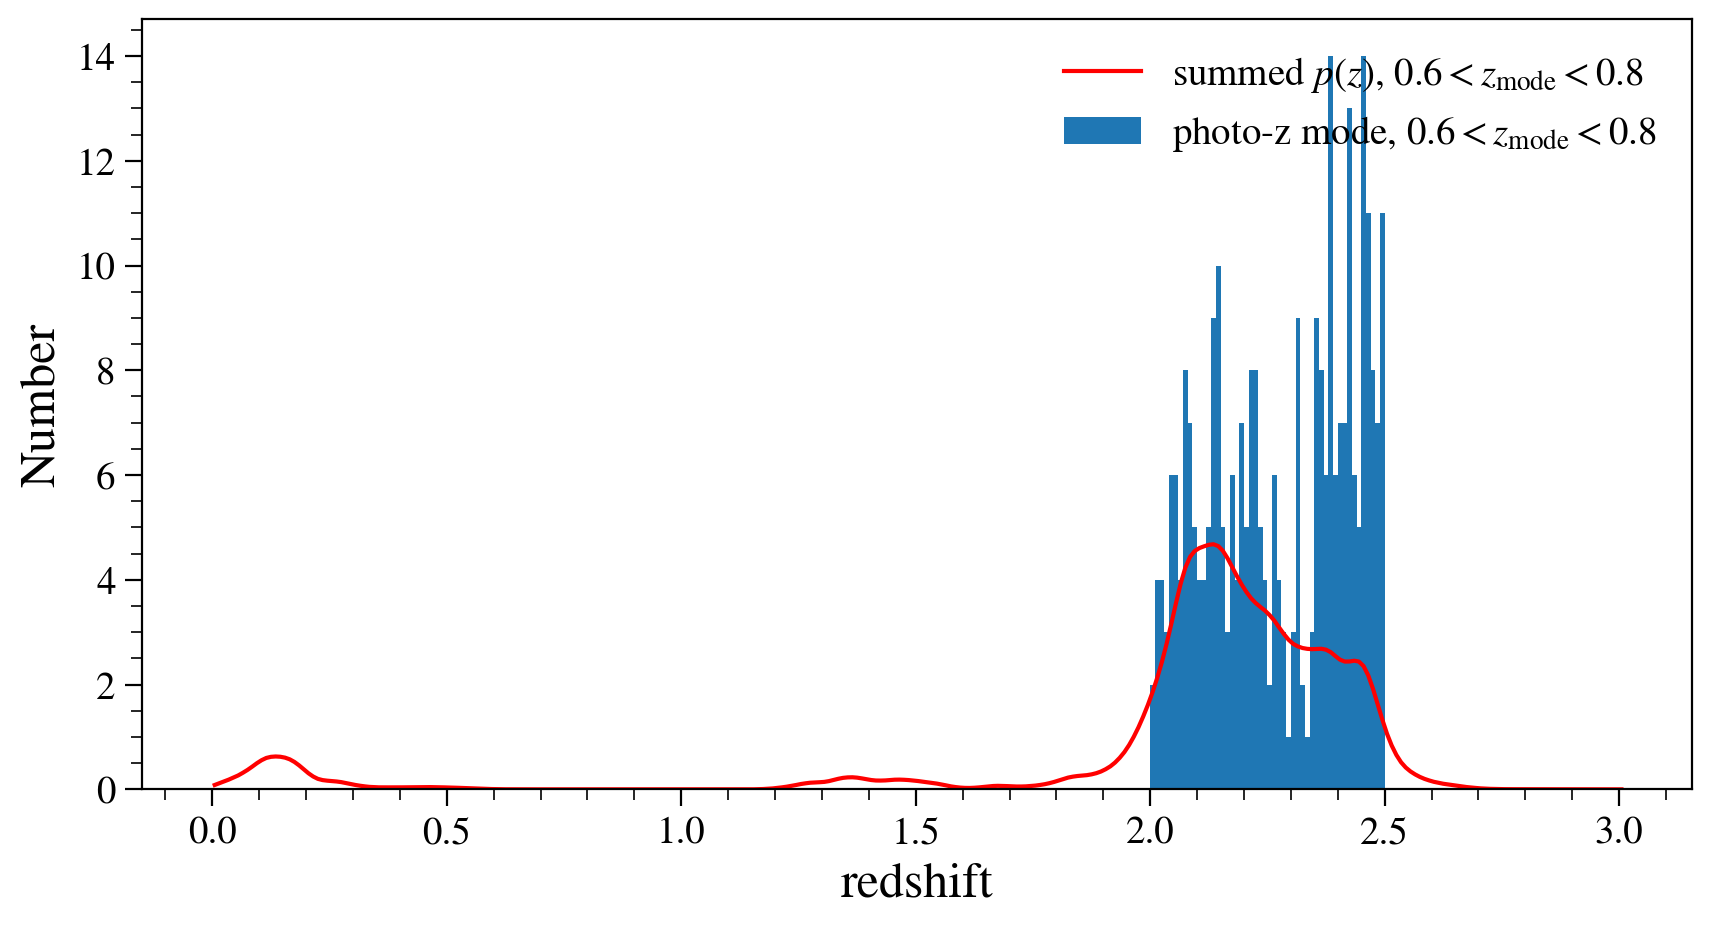

In [18]:
fig = plt.figure(figsize=(10,5))
plt.hist(data['photoz_mode'][bin_cut], bins = np.arange(0.0,3.01,.01), label=r'photo-z mode, $0.6 < z_{\rm mode} < 0.8$');
plt.plot(cat.photoz_pdf_bin_centers, sumpdf_bin,c='r', label=r'summed $p(z)$, $0.6 < z_{\rm mode} < 0.8$');
plt.xlabel("redshift",fontsize=18);
plt.ylabel("Number",fontsize=18)
plt.legend(loc='upper right');
#plt.xlim(0.25,1.25)

We see that the sum of the PDFs indicates that there are potential degenerate solutions at both z~0.2 and 1.4 with non-negligible probability.  We also see that the relative height fo the two peaks in the 2<z<2.5 bin is rather different between the `photoz_mode` histogram and the sum of `photoz_pdf`.  Let's plot the colors of these galaxies:

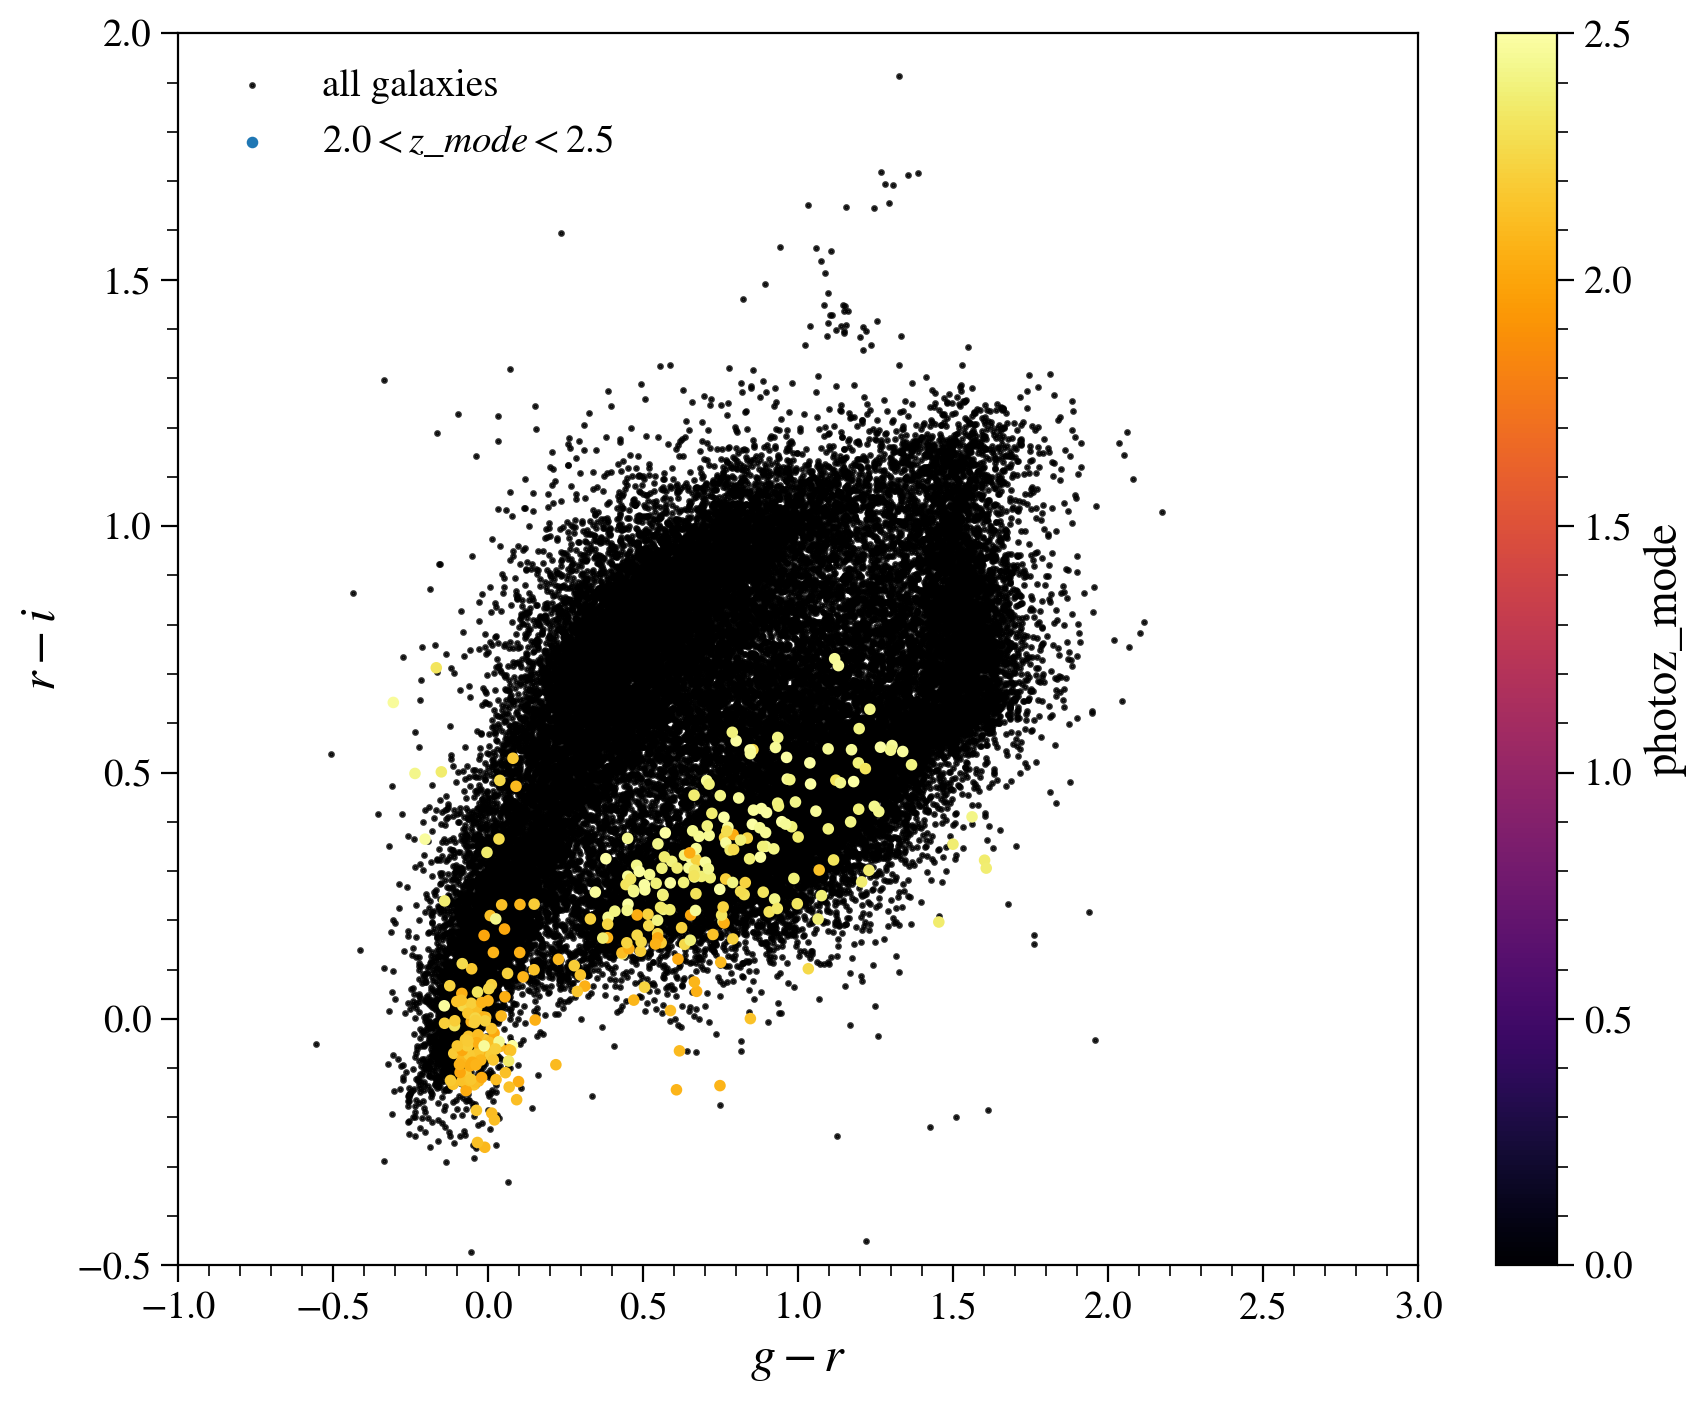

In [19]:
fig = plt.figure(figsize=(10,8))
plt.scatter(data['mag_g_cModel'] - data['mag_r_cModel'],
            data['mag_r_cModel'] - data['mag_i_cModel'],
            c='k',s=2,alpha=0.8,label='all galaxies');
plt.scatter(data['mag_g_cModel'][bin_cut] - data['mag_r_cModel'][bin_cut],
            data['mag_r_cModel'][bin_cut] - data['mag_i_cModel'][bin_cut],
            c=data['photoz_mode'][bin_cut], s=10, vmin=0, vmax=2.5, cmap='inferno',
            label='$2.0<z\_mode<2.5$');

plt.xlim(-1, 3);
plt.ylim(-0.5, 2);
plt.xlabel('$g-r$',fontsize=18);
plt.ylabel('$r-i$',fontsize=18);
plt.colorbar(label='photoz_mode');
plt.legend(loc='upper left')

We see that galaxies with `photoz_mode` between 2.0 and 2.5 reside in several areas of color space, including an area of potential degeneracy near g-r ~ r-i ~ 0 where galaxies at both low and high redshift reside.  This is not uncommon for high redshift galaxies, which tend to have very blue, power-law-like SEDs, which tend to have blue colors at nearly all redshifts, and are thus prone to degeneracies.